## Predictsystem (April 2018)
This notebook generates predictions using the features generated by Naireen's most recent model.

In [1]:
import pickle
import rebound
import numpy as np
import pandas as pd
import run_Nbody_inc as Nbod
import generatefeatures as gen
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
model_features = ['avg_iH1', 'avg_iH2', 'norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1',
                  'norm_max_window10_a1','norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2',
                  'norm_max_window10_a2','norm_std_a3','norm_max_a3', 'norm_std_window10_a3',
                  'norm_max_window10_a3', 'avg_ecross1', 'std_ecross1','max_ecross1', 'min_ecross1',
                  'avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2','avg_ecross3',
                  'std_ecross3', 'max_ecross3', 'min_ecross3', 'norm_a1_slope', 'norm_a2_slope',
                  'norm_a3_slope', 'avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23',
                  'std_beta23','min_beta23','max_beta23']

In [27]:
def predictsystem(system, ext, shadow, x, y):
    names = ["name","id","shadow","maxorbs","P1","sim_time","Eerr","CPU_time"]
    if ext == '_inc':
        names += ["inc1","inc2","inc3","Omega1","Omega2","Omega3"]
    
    # load data
    data = pd.read_csv("systems/%s_data.csv"%system, index_col=0)
    Nbodydata = pd.read_csv("systems/%s_Nbodyresults%s.csv"%(system, ext), names=names)
    features = pd.read_csv('systems/%s_features%s.csv'%(system, ext))
    model = pickle.load(open("models/final_Naireen2018.pkl", "rb"))

    #get e
    try:
        data["e1"] = np.sqrt(data["h1"]**2 + data["k1"]**2)
        data["e2"] = np.sqrt(data["h2"]**2 + data["k2"]**2)
        data["e3"] = np.sqrt(data["h3"]**2 + data["k3"]**2)
    except:
        print "can't find h and k entries, calculating."
        data["h1"], data["k1"] = data["e1"]*np.sin(data["w1"]), data["e1"]*np.cos(data["w1"])
        data["h2"], data["k2"] = data["e2"]*np.sin(data["w2"]), data["e2"]*np.cos(data["w2"])
        data["h3"], data["k3"] = data["e3"]*np.sin(data["w3"]), data["e3"]*np.cos(data["w3"])
        
    # organize data tables
    feat = features[features["shadow"]==shadow]
    Nbody = Nbodydata[Nbodydata["shadow"]==shadow]
    Nbody = Nbody[Nbody["id"]==feat["id"]]
    plotdata = data.iloc[Nbody["id"]]
    plotdata["id"] = plotdata.index

    feat = feat.reset_index(drop=True)
    Nbody = Nbody.reset_index(drop=True)
    plotdata = plotdata.reset_index(drop=True)
    
    print("**confirm ids line up for feat, Nbody, plotdata:**")
    r = np.random.randint(0,len(feat)-5)
    print(zip(feat["id"].iloc[r:r+5], Nbody["id"].iloc[r:r+5], plotdata["id"].iloc[r:r+5]))
    
    # get preds
    X = xgb.DMatrix(feat[model_features])
    proba = model.predict(X)
    pstablemask = (proba > 0.5)
    punstablemask = (proba <= 0.5)

    # get Nbody
    stablemask = Nbody.sim_time/Nbody.P1 >=9.9e8
    unstablemask = Nbody.sim_time/Nbody.P1 < 9.9e8
    
    # plot
    colorbar = 'winter'
    size=70
    cmap = matplotlib.cm.get_cmap(colorbar)
    f, (ax1, ax2) = plt.subplots(1,2, figsize=[9, 5], sharex=True, sharey=True)
    ax1.scatter(plotdata[x][stablemask], plotdata[y][stablemask], c=cmap(0.99), lw=0, s=size, label='stable')
    ax1.scatter(plotdata[x][unstablemask], plotdata[y][unstablemask], c=cmap(0.), lw=0, s=size, label='unstable')
    ax2.scatter(plotdata[x][pstablemask], plotdata[y][pstablemask], c=cmap(0.99), lw=0, s=size)
    ax2.scatter(plotdata[x][punstablemask], plotdata[y][punstablemask], c=cmap(0.), lw=0, s=size)
    ax1.set_xlabel(x); ax2.set_xlabel(x); ax1.set_ylabel(y);
    ax1.set_title("Nbody", fontsize=16); ax2.set_title("Predictions", fontsize=16)
    ax1.legend(fontsize=8)
    ax1.set_ylim([-0.2, 0.2])
    plt.subplots_adjust(wspace=0)

    # calculate precision and recall
    Tp = ((pstablemask == True) & (stablemask == True)).sum()
    Fp = ((pstablemask == True) & (stablemask == False)).sum()
    Fn = ((pstablemask == False) & (stablemask == True)).sum()
    plt.suptitle("precision=%f, recall=%f, N=%d"%(float(Tp)/(Tp+Fp), float(Tp)/(Tp+Fn), len(stablemask)), fontsize=16)
    
    plt.savefig('output/%s%s_%s_v_%s.png'%(system, ext, x, y))

can't find h and k entries, calculating.
**confirm ids line up for feat, Nbody, plotdata:**
[(323, 323, 323), (926, 926, 926), (1153, 1153, 1153), (285, 285, 285), (418, 418, 418)]


/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


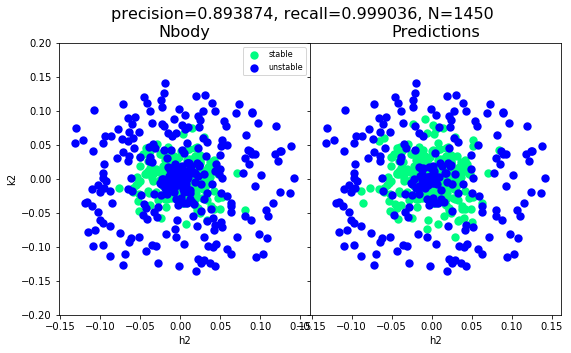

In [28]:
# systems = ["Kepler-431","Kepler-446","KOI-0085","KOI-0115","KOI-0156",
#            "KOI-0168","KOI-0250","KOI-0314","KOI-1576","KOI-2086","LP-358-499"]
systems = ["Kepler-431"]
ext = ''   #'_inc' or ''
shadow = 0
x = "h2"
y = "k2"

for system in systems:
    try:
        predictsystem(system, ext, shadow, x, y)
    except:
        print("!!couldnt process %s!!"%system)

### Extra Analysis - Compare Nbody results of inc=0 with inc>0

In [133]:
system = "KOI-0115"

In [134]:
def get_sys(system, ext):
    names = ["name","id","shadow","maxorbs","P1","sim_time","Eerr","CPU_time"]
    if ext == '_inc':
        names += ["inc1","inc2","inc3","Omega1","Omega2","Omega3"]

    # load data
    Nbody = pd.read_csv("systems/%s_Nbodyresults%s.csv"%(system, ext), names=names)
    feat = pd.read_csv('systems/%s_features%s.csv'%(system, ext))
    return Nbody, feat

In [135]:
data = pd.read_csv("systems/%s_data.csv"%system, index_col=0)
Nbody, feat = get_sys(system, "")
Nbody_inc, feat_inc = get_sys(system, "_inc")

# combine all into one data frame
df = reduce(lambda left,right: pd.merge(left,right,on=['id','shadow']), [Nbody, feat, Nbody_inc, feat_inc])

In [136]:
df.head()

,name_x,id,shadow,maxorbs_x,P1_x,sim_time_x,Eerr_x,CPU_time_x,Unnamed: 0_x,avg_iH1_x,...,norm_a3_slope_y,avg_beta12_y,std_beta12_y,min_beta12_y,max_beta12_y,avg_beta23_y,std_beta23_y,min_beta23_y,max_beta23_y,name_y
0,KOI-0115_1e9orbits_id97_shadow0,97,0,1.000000e+09,0.059160,59160410.0,3.208418e-08,42631.52,0,0.0,...,7.227874e-08,37.328538,13.423721,10.591071,51.575011,5.123649,3.020327,0.717858,14.309851,KOI-0115_1.0e+09orbits_id97_shadow0
1,KOI-0115_1e9orbits_id68_shadow0,68,0,1.000000e+09,0.059157,59157290.0,9.144957e-08,42685.73,1,0.0,...,-2.728219e-11,15.767086,0.014488,15.730769,15.814130,9.105904,0.020546,9.047745,9.149788,KOI-0115_1.0e+09orbits_id68_shadow0
2,KOI-0115_1e9orbits_id255_shadow0,255,0,1.000000e+09,0.059155,59154750.0,3.197804e-08,42521.81,2,0.0,...,-4.482387e-12,19.455108,0.033246,19.367426,19.498739,10.263706,0.049628,10.200350,10.388869,KOI-0115_1.0e+09orbits_id255_shadow0
3,KOI-0115_1e9orbits_id48_shadow1,48,1,1.000000e+09,0.059153,59153260.0,2.763320e-08,42691.94,3,0.0,...,5.225540e-11,20.502222,0.031248,20.437745,20.545844,9.860245,0.045495,9.796158,9.952706,KOI-0115_1.0e+09orbits_id48_shadow1
4,KOI-0115_1e9orbits_id338_shadow1,338,1,1.000000e+09,0.059151,59151220.0,2.364662e-08,42788.10,4,0.0,...,1.780414e-11,19.218137,0.013142,19.183217,19.241075,10.940594,0.021411,10.902467,10.981749,KOI-0115_1.0e+09orbits_id338_shadow1


In [137]:
df.columns

Index([u'name_x', u'id', u'shadow', u'maxorbs_x', u'P1_x', u'sim_time_x',
       u'Eerr_x', u'CPU_time_x', u'Unnamed: 0_x', u'avg_iH1_x', u'avg_iH2_x',
       u'norm_std_a1_x', u'norm_max_a1_x', u'norm_std_window10_a1_x',
       u'norm_max_window10_a1_x', u'norm_std_a2_x', u'norm_max_a2_x',
       u'norm_std_window10_a2_x', u'norm_max_window10_a2_x', u'norm_std_a3_x',
       u'norm_max_a3_x', u'norm_std_window10_a3_x', u'norm_max_window10_a3_x',
       u'avg_ecross1_x', u'std_ecross1_x', u'max_ecross1_x', u'min_ecross1_x',
       u'avg_ecross2_x', u'std_ecross2_x', u'max_ecross2_x', u'min_ecross2_x',
       u'avg_ecross3_x', u'std_ecross3_x', u'max_ecross3_x', u'min_ecross3_x',
       u'norm_a1_slope_x', u'norm_a2_slope_x', u'norm_a3_slope_x',
       u'avg_beta12_x', u'std_beta12_x', u'min_beta12_x', u'max_beta12_x',
       u'avg_beta23_x', u'std_beta23_x', u'min_beta23_x', u'max_beta23_x',
       u'name_y', u'name_x', u'maxorbs_y', u'P1_y', u'sim_time_y', u'Eerr_y',
       u'CPU_time_

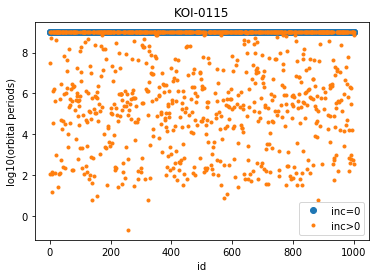

In [140]:
#plt.plot(df['avg_iH1_x']+df['avg_iH2_x'], np.log10(df['sim_time_x']/df['P1_x']), 'o', label='inc=0')
#plt.plot(df['inc1']+df['inc2']+df['inc3'],np.log10(df['sim_time_y']/df['P1_y']), '.', label='inc>0')
plt.plot(np.log10(df['sim_time_x']/df['P1_x']), 'o', label='inc=0')
plt.plot(np.log10(df['sim_time_y']/df['P1_y']), '.', label='inc>0')
plt.ylabel('log10(orbital periods)')
plt.xlabel('id')
plt.title(system)
plt.legend(loc='lower right')
#plt.savefig('output/%s_inc>0_vs_inc=0_comp.png'%system)

## Tryna reproduce the old Kepler-431 predictions

In [36]:
systems = ["Kepler-431"]
shadow = 0
x = "h2"
y = "k2"

can't find h and k entries, calculating.


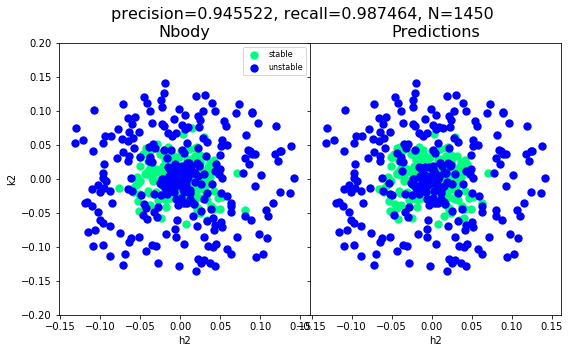

In [41]:
names = ["name","id","shadow","maxorbs","P1","sim_time","Eerr","CPU_time"]

# load data
data = pd.read_csv("systems/%s_data.csv"%system, index_col=0)
Nbodydata = pd.read_csv("systems/%s_Nbodyresults.csv"%(system), names=names)
preds = pd.read_csv('systems/backup/%s_preds.csv'%(system))

#get e
try:
    data["e1"] = np.sqrt(data["h1"]**2 + data["k1"]**2)
    data["e2"] = np.sqrt(data["h2"]**2 + data["k2"]**2)
    data["e3"] = np.sqrt(data["h3"]**2 + data["k3"]**2)
except:
    print "can't find h and k entries, calculating."
    data["h1"], data["k1"] = data["e1"]*np.sin(data["w1"]), data["e1"]*np.cos(data["w1"])
    data["h2"], data["k2"] = data["e2"]*np.sin(data["w2"]), data["e2"]*np.cos(data["w2"])
    data["h3"], data["k3"] = data["e3"]*np.sin(data["w3"]), data["e3"]*np.cos(data["w3"])

# join data
data["id"] = data.index
preds["id"] = preds.index
Nbody = Nbodydata[(Nbodydata["shadow"]==0)]
plotdata = reduce(lambda left,right: pd.merge(left,right,on=['id']), [data, Nbody, preds])

# get preds
proba = plotdata['ApplicationsModel_predict_proba']
pstablemask = (proba > 0.5)
punstablemask = (proba <= 0.5)

# get Nbody
stablemask = plotdata['sim_time']/plotdata['P1_y'] >= 9.9e8
unstablemask = plotdata['sim_time']/plotdata['P1_y'] < 9.9e8

# plot
colorbar = 'winter'
size=70
cmap = matplotlib.cm.get_cmap(colorbar)
f, (ax1, ax2) = plt.subplots(1,2, figsize=[9, 5], sharex=True, sharey=True)
ax1.scatter(plotdata[x][stablemask], plotdata[y][stablemask], c=cmap(0.99), lw=0, s=size, label='stable')
ax1.scatter(plotdata[x][unstablemask], plotdata[y][unstablemask], c=cmap(0.), lw=0, s=size, label='unstable')
ax2.scatter(plotdata[x][pstablemask], plotdata[y][pstablemask], c=cmap(0.99), lw=0, s=size)
ax2.scatter(plotdata[x][punstablemask], plotdata[y][punstablemask], c=cmap(0.), lw=0, s=size)
ax1.set_xlabel(x); ax2.set_xlabel(x); ax1.set_ylabel(y);
ax1.set_title("Nbody", fontsize=16); ax2.set_title("Predictions", fontsize=16)
ax1.legend(fontsize=8)
ax1.set_ylim([-0.2, 0.2])
plt.subplots_adjust(wspace=0)

# calculate precision and recall
Tp = ((pstablemask == True) & (stablemask == True)).sum()
Fp = ((pstablemask == True) & (stablemask == False)).sum()
Fn = ((pstablemask == False) & (stablemask == True)).sum()
plt.suptitle("precision=%f, recall=%f, N=%d"%(float(Tp)/(Tp+Fp), float(Tp)/(Tp+Fn), len(stablemask)), fontsize=16)
    
plt.savefig('output/old_%s_%s_v_%s.png'%(system, x, y))